In [13]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
#from sklearn.pipeline import make_pipeline, make_union
import statsmodels.api as sm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from climada.util.constants import DEF_CRS


#from sklearn_xarray import Stacker, Select

In [14]:
##function definition
from functions import *
from climada_functions import *
from constants import * 

## Select and load data

In [15]:
## select data
#select variable (cmip6 naming)
selvar = 'sfcWindmax'
pathinvar = pathcmip6+'sfcWindmax/'

#preprocessing 
gst_fact = 1.67
qt = 0.98
cut=2E6
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["br_rg"] #base resolution regridded
timeres = ["day"]
domain = ["EU"]
season = ["winE"]
scen = ["allscens"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season+scen
basenamemet = sep.join(lst_bn)

#preproc field
processings = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(cut,'.0E').replace("+0",''),"gst1-67"]
basenamemet_proc = make_fn(processings,basenamemet)

#dic to map each impact func to its preprocessing function
pp_func_dic = {'Cubic excess-over-threshold':scale_qt,'Emanuel 2011':mask_qt,'Welker 2021':mask_qt}

## Load indices

In [16]:
##Member mean

#normalized
dind_fn = "diff_remote_indices_sp_avg_modlist_allscen_historical_ssp585.csv"
dind_df = pd.read_csv(pathcirc+dind_fn,header=[0],index_col=[0,1])

dind_memmean_df = dind_df.copy()
# get member mean
dind_memmean_df = dind_memmean_df.groupby("model",axis=0).mean()

# add multimodel mean
dind_memmean_df.loc["mean"] =  dind_memmean_df.mean()

# anomalies
an_dind_memmean_df = dind_memmean_df.iloc[:-1]-dind_memmean_df.loc["mean"]

# standardized
std_an_dind_memmean_df = an_dind_memmean_df/dind_df.std()


In [17]:
##Memsep 
dind_memsep_df = dind_df.copy()
# add multimodel mean

dind_memsep_df.loc[("mean",""),:] =  dind_memsep_df.mean()

# anomalies
an_dind_memsep_df = dind_memsep_df.iloc[:-1]-dind_memsep_df.loc[("mean",""),:]

# standardized
std_an_dind_memsep_df = an_dind_memsep_df/dind_df.std()


In [18]:
std_an_dind_memsep_df

sfcT       pol      trop     strat
model            imem                                        
CanESM5          0     1.800450  1.867830  1.796681  0.921386
                 1     1.742826  1.804418  1.787742  0.598489
                 2     1.670426  1.537200  1.736449 -0.360470
CNRM-CM6-1       0     0.404906  0.151950  0.815318  1.064869
                 1     0.462936 -0.012748  0.878675 -1.667423
                 2     0.646668  0.352945  0.937741 -1.685248
CNRM-ESM2-1      0    -0.032781 -0.302638  0.424604 -0.322182
                 1    -0.022694 -0.395910  0.455555 -1.803939
                 2     0.259760  0.319440  0.581756 -1.345902
EC-Earth3-Veg    0     0.075511 -0.124832  0.109085 -0.127299
                 1     0.415440  0.630196  0.208351 -1.541649
                 2     0.103693  0.047088  0.058579 -0.483567
EC-Earth3-Veg-LR 0    -0.060727  0.057493  0.045064 -1.007029
                 1     0.389334  0.630875  0.223476 -0.288773
                 2     0.473342  0.963840  0.267838 -1.267407
IPSL-CM6A-LR     0     0.694192  0.442109  1.012998  0.521420
                 1     0.725202  0.501234  1.006850  0.824961
                 2     0.421127  0.057137  0.784737  0.751034
MIROC-ES2L       0    -0.779079 -0.303895 -0.541285  1.527503
                 1    -0.890890 -0.411796 -0.672782  0.913465
                 2    -0.940468 -0.510548 -0.610525  1.161521
UKESM1-0-LL      0     1.741758  1.446797  1.171422 -0.959344
                 1     1.975320  1.692102  1.278303 -0.404893
                 2     1.689542  1.186976  1.166956 -0.856407
MRI-ESM2-0       0    -0.543725 -0.262138 -0.343093  1.477965
                 1    -0.571446 -0.412222 -0.302682  0.357570
                 2    -0.563584 -0.296883 -0.369344 -0.732123
FGOALS-g3        0    -1.455972 -0.812600 -1.102546 -0.613413
                 1    -1.521407 -0.964999 -1.128300 -0.498329
                 2    -1.944876 -1.363996 -1.492298 -0.882837
ACCESS-ESM1-5    0    -0.211816 -0.013195 -1.760595 -0.093380
                 1    -0.154286  0.015477 -1.706829 -0.112475
                 2    -0.180306  0.066557 -1.712257 -0.073819
MIROC6           0    -1.132124 -0.327534 -1.096171  0.269222
                 1    -1.107132 -0.531127 -1.048700 -0.156539
                 2    -1.033494 -0.222559 -0.996172  0.242937
MPI-ESM1-2-LR    0    -1.220882 -0.825121 -0.969651  0.764641
                 1    -1.171647 -0.730939 -0.866581  1.217712
                 2    -1.107674 -0.553378 -0.955503  0.683026
KACE-1-0-G       0     0.329036 -4.059340  0.301623  2.563654
                 1     0.377924 -0.037573  0.351201  0.754066
                 2     0.247619 -0.295691  0.274311  0.669005

## Prepare model target variable

In [19]:
#select vars
modlist = modlist_allscen
nmods = len(modlist)
pastname = 'historical'
futname = 'ssp585'
timeres='day'
nmems = 3
memrange = np.arange(nmems)
qt = 0.98
lonout = np.arange(min_lon+2.5,max_lon-2.5,2.5)
latout = np.arange(min_lat+2.5,max_lat-2.5,2.5)
norm = True #normalize by global warming

In [20]:
#intiate ds to save result
nameds = futname+'-'+pastname
qtgust_ds = xr.DataArray(np.zeros([latout.size, lonout.size,nmods ,nmems]), 
                                          coords=[latout, lonout, modlist, memrange], dims=['lat','lon','model','member'], name=nameds)
                

In [21]:
#surface temperature for normalizing
Ts_df = std_an_dind_memsep_df.loc[modlist,["sfcT"]]

#loop over the models
for modid, modname in enumerate(modlist):  
    
    #read netcdf
    fn = make_fn([modname],basenamemet,filetype=".nc")
    ncdf = xr.open_dataset(pathinvar+fn)
    ncdfw = ncdf[[pastname,futname]]
    
    #apply gust factor
    gust_ds = gst_fact*ncdfw
    
    #get 98 quantile
    gust_qt_ds = gust_ds.quantile(qt,dim=timeres)
    
    #compute fut -past diff
    gust_qt_past = gust_qt_ds[pastname]
    gust_qt_fut = gust_qt_ds[futname]
    gust_qt_diff = gust_qt_fut - gust_qt_past
    
    #regrid
    gust_qt_diff = gust_qt_diff.interp(coords={"lat":latout,"lon":lonout})
    #gust_coarsen = gust_qt_diff.coarsen(dim={"lat":2,"lon":2},boundary='trim').mean()
    
    if norm:
        for imem in range(nmems):
            Tsmem = Ts_df.loc[(modname,imem)].values
            gust_qt_diff.loc[{"member":imem}] = gust_qt_diff.loc[{"member":imem}]/Tsmem
    #write to ds
    qtgust_ds.loc[{"model":modname,"member":[0,1,2]}] = gust_qt_diff
    

## Robust regression on q98 of wind
1) Select simulation
2) Intiate df to save results
3) Loop over models, compute q98 fut-past diff, regrid and concat into the same array
5) regression on each gridcell of the q98 map



In [22]:
##select simulation

#models
modlist = modlist_allscen

#predictors 
preds = ["pol","trop","strat"]


In [112]:
#initiate arrays
nlat = len(latout)
nlon = len(lonout)
arr_dict = {}
to_save = preds+["intercept","Rsq","adj_Rsq"]
for item in to_save:
    arr_dict[item] = xr.DataArray(np.zeros([latout.size, lonout.size]), 
                                          coords=[latout, lonout], dims=['lat','lon'], name=item)
                

In [103]:
##select indices and response scikit learn
X = std_an_dind_memsep_df.loc[modlist,preds]
Ts = std_an_dind_memsep_df.loc[modlist,["sfcT"]]
yy = qtgust_ds.sel(model=modlist)

if norm:
    X = X/Ts.values
    
for ii in np.arange(0,nlat,1):
    for jj in np.arange(0,nlon,1):
#         ----------------------------
        y_grid_point = yy.isel(lat=ii,lon=jj).values.flatten()
        #construct model
        model_l = LinearRegression().fit(X,y_grid_point)
        #coefs
        intercept = model_l.intercept_
        coefs = model_l.coef_
        #rsq
        rsq = model_l.score(X,y_grid_point)
        adj_rsq = 1 - (1-rsq)*(len(y_grid_point)-1)/(len(y_grid_point)-X.shape[1]-1)
        
        #save to array
        arr_dict["intercept"][ii,jj] = intercept
        arr_dict["Rsq"][ii,jj] = rsq
        arr_dict["adj_Rsq"][ii,jj] = adj_rsq
        for ip,pred in enumerate(model_l.feature_names_in_):
            arr_dict[pred][ii,jj] = coefs[ip]
        
res_ds1 = xr.Dataset(arr_dict)

In [23]:
#initiate arrays
nlat = len(latout)
nlon = len(lonout)
arr_dict = {}
arr_dict_pval = {}
to_save = preds+["const","Rsq","adj_Rsq"]
for item in to_save:
    arr_dict[item] = xr.DataArray(np.zeros([latout.size, lonout.size]), 
                                          coords=[latout, lonout], dims=['lat','lon'], name=item)
for item in preds+["const"]:
    arr_dict_pval[item] = xr.DataArray(np.zeros([latout.size, lonout.size]), 
                                          coords=[latout, lonout], dims=['lat','lon'], name=item)
        

In [24]:
##select indices and response statsmodel
X = std_an_dind_memsep_df.loc[modlist,preds]
X = sm.add_constant(X) # adding a constant
Ts = std_an_dind_memsep_df.loc[modlist,["sfcT"]]
yy = qtgust_ds.sel(model=modlist)

if norm:
    X = X/Ts.values
    
for ii in np.arange(0,nlat,1):
    for jj in np.arange(0,nlon,1):
#         ----------------------------
        #select response variable at gridpoint
        y_grid_point = yy.isel(lat=ii,lon=jj).values.flatten()
    
        #construct model
        lm = sm.RLM(y_grid_point, X, M=sm.robust.norms.TukeyBiweight()) # describe model
        fit = lm.fit() # fit model
        
        #save to array
        #arr_dict["Rsq"][ii,jj] = fit.rsquared
        #arr_dict["adj_Rsq"][ii,jj] = fit.rsquared_adj
        for name,value in fit.params.items():
            arr_dict[name][ii,jj] = value
            
        for name,value in fit.pvalues.items():
            arr_dict_pval[name][ii,jj] = value
        
res_ds2 = xr.Dataset(arr_dict)
pval_ds = xr.Dataset(arr_dict_pval)

## Plot indices

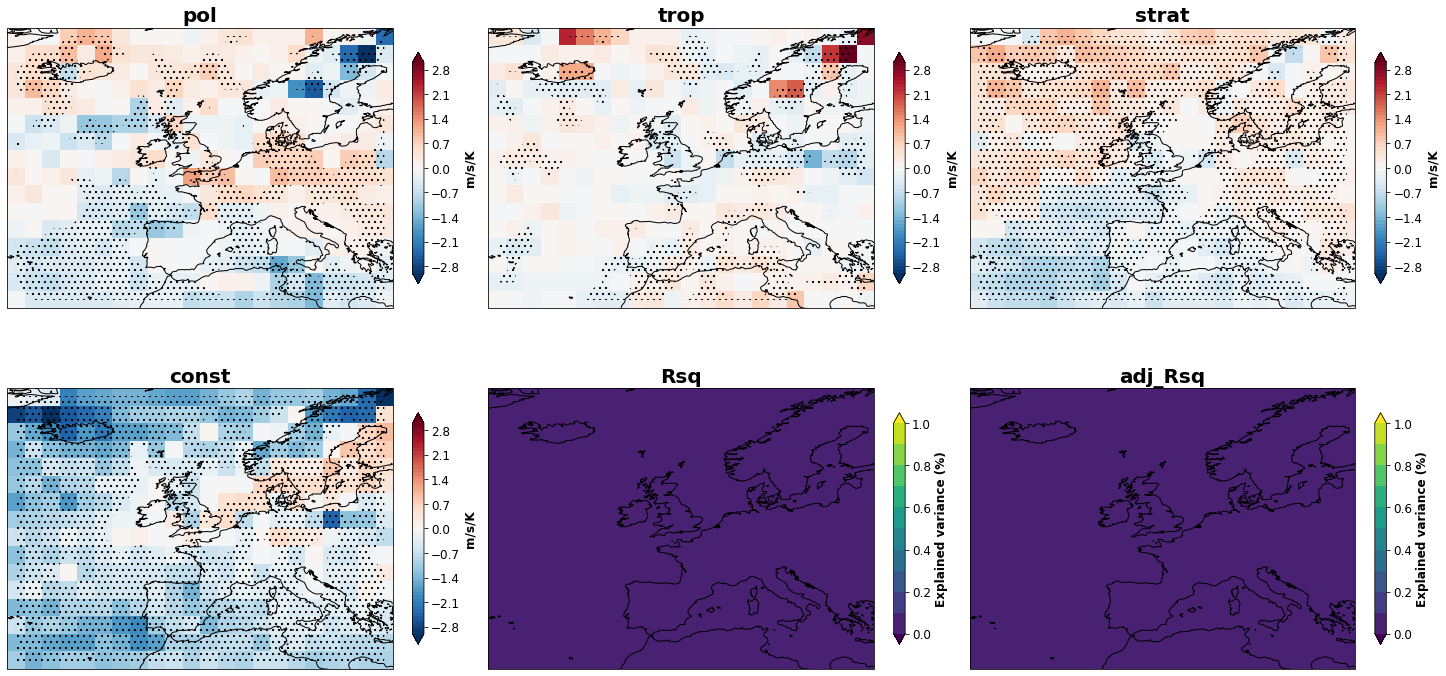

In [25]:
add_pvals = True
data = res_ds2
fig = plt.figure(constrained_layout=True,figsize=(20,10))
axs = fig.subplots(nrows=2, ncols=3,subplot_kw={'projection': ccrs.PlateCarree()}).flatten()
#labels
labels = ['m/s/K', 'm/s/K' , 'm/s/K', 'm/s/K', 'Explained variance (%)', 'Explained variance (%)']

#color levels
colorbarMin=-3
colorbarMax=3
colorspace=0.1
clevel_coef = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

colorbarMin=0
colorbarMax=1
colorspace=0.1
clevel_R = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)

dict_cbar = {"pol": [clevel_coef,'RdBu_r'], "trop": [clevel_coef,'RdBu_r'], "strat":[clevel_coef,'RdBu_r'], "const":[clevel_coef,'RdBu_r'],
             "Rsq":[clevel_R,'viridis'],"adj_Rsq":[clevel_R,'viridis']}

#hatches pvals
hatches =  ['..','']
p_levels = [0.0, 0.025]

for i,varname in enumerate(data.keys()):
    axi = axs[i]
    da = data[varname]
    clevs = dict_cbar[varname][0]
    color = dict_cbar[varname][1]

    h = da.plot(ax=axi,extend='both',levels=clevs,cmap=color,add_colorbar=False)
    
    #plot the colorbar:
    cbar = fig.colorbar(h, ax=axi,orientation='vertical', fraction=0.03, pad=0.05)
    cbar.ax.tick_params(labelsize=12) 
    colorLabel='[m/s]' 
    colorbarMin=-3
    label = labels[i]
    cbar.set_label(label=label,fontsize=12,fontweight='bold')
    
    #pvals
    if add_pvals:
        if varname in preds+["const"]:
            da_pv = pval_ds[varname]
            da_pv.plot.contourf(ax=axi,colors='none',levels=p_levels,hatches=hatches,extend='neither',add_colorbar=False)
    
    axi.set_title(varname,fontsize=20,fontweight='bold')
    # coastlines
    axi.coastlines()
    axi.set_visible(True)